In [1]:
# Colab에 Khaiii 설치

import os
!git clone https://github.com/kakao/khaiii.git
!pip install cmake
!mkdir build
!cd build && cmake /content/khaiii
!cd /content/build/ && make all
!cd /content/build/ && make resource
!cd /content/build && make install
!cd /content/build && make package_python
!pip install /content/build/package_python


Cloning into 'khaiii'...
remote: Enumerating objects: 80, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 957 (delta 25), reused 49 (delta 19), pack-reused 877
Receiving objects: 100% (957/957), 33.03 MiB | 30.34 MiB/s, done.
Resolving deltas: 100% (383/383), done.
-- [hunter] Initializing Hunter workspace (70287b1ffa810ee4e952052a9adff9b4856d0d54)
-- [hunter]   https://github.com/ruslo/hunter/archive/v0.23.34.tar.gz
-- [hunter]   -> /root/.hunter/_Base/Download/Hunter/0.23.34/70287b1
-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-

In [2]:
# Khaiii 사용자 사전 추가
''' 
** Khaiii 사용자 사전 추가를 참고  **
preanal.manual 데이터를 download 받아서,
colab -> /content/khaiii/rsc/src 파일에 붙여넣기
'''

!cd /content/khaiii/rsc
!mkdir -p /content/build/share/khaiii
!PYTHONPATH=/content/khaiii/src/main/python /content/khaiii/rsc/bin/compile_preanal.py --rsc-src=/content/khaiii/rsc/src --rsc-dir=/content/build/share/khaiii

INFO:root:preanal.manual
INFO:root:preanal.auto
ERROR:root:preanal.auto:4555: [DUPLICATED] with "가득*	가득/NNP": "가득	가득/MAG"
ERROR:root:preanal.auto:4703: [DUPLICATED] with "가마솥*	가마솥/NNP": "가마솥	가마솥/NNG"
ERROR:root:preanal.auto:4909: [DUPLICATED] with "가을*	가을/NNP": "가을	가을/NNG"
ERROR:root:preanal.auto:4985: [DUPLICATED] with "가정용*	가정용/NNP": "가정용	가정/NNG + 용/XSN"
ERROR:root:preanal.auto:5250: [DUPLICATED] with "각종*	각종/NNP": "각종	각종/NNG"
ERROR:root:preanal.auto:5756: [DUPLICATED] with "감자*	감자/NNP": "감자	감자/NNG"
ERROR:root:preanal.auto:5931: [DUPLICATED] with "강릉*	강릉/NNP": "강릉	강릉/NNP"
ERROR:root:preanal.auto:6296: [DUPLICATED] with "개개*	개개/NNP": "개개	개개/NNG"
ERROR:root:preanal.auto:6555: [DUPLICATED] with "개입*	개입/NNP": "개입	개입/NNG"
ERROR:root:preanal.auto:7122: [DUPLICATED] with "건강한*	건강한/NNP": "건강한	건강/NNG + 하/XSA + ㄴ/ETM"
ERROR:root:preanal.auto:7959: [DUPLICATED] with "겨울*	겨울/NNP": "겨울	겨울/NNG"
ERROR:root:preanal.auto:8891: [DUPLICATED] with "곁들여*	곁들여/NNP": "곁들여	곁들이/VV + 어/EC"
ERROR:root:preanal.a

## Gensim Topic Modeling


In [110]:
import pandas as pd


data = pd.read_csv('/content/final_input.csv', encoding='utf-8').drop(['Unnamed: 0'], axis=1)

In [111]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1566 entries, 0 to 1565
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Nickname  1566 non-null   object
 1   Review    1566 non-null   object
dtypes: object(2)
memory usage: 24.6+ KB


# Gensim LDA를 위한 데이터 전처리
## Experiment 1) Khaiii에서 명사, 어근만 추출해 Tokenizing




In [112]:
from khaiii import KhaiiiApi
api = KhaiiiApi(rsc_dir="/content/build/share/khaiii")

n_tags = ['NNG', 'NNP', 'NNB', 'XR']#, 'VV', "VA"] # 동사도 넣고 싶으면 추가

'''
input : 추출할 Review의 list ;
output : n_tags의 tag와 일치하는 text list ; 
'''

def extract_corpus_khaiii(texts):
    extract_corpus = []
    for line in texts:
      if str(line) != 'nan':
        nouns = []

        for word in api.analyze(str(line)):
          for morphs in word.morphs:
            if morphs.tag in n_tags:
              if len(morphs.lex) > 1:
                nouns.append(morphs.lex)
              else:
                continue

        extract_corpus.append(nouns)

    return extract_corpus
  

In [113]:
# 네이버 영수증 리뷰, 인스타 리뷰에서 명사, 어근을 추출
khaiii_xr = extract_corpus_khaiii(data['Review']) 
#khaiii_all = extract_corpus_khaiii(data['Review']) # 명사, 동사, 형용사, 어근 모두 추출

In [114]:
# 추출 전 데이터와 비교

print(len(data), len(khaiii_xr))
#print(len(data), len(khaiii_all))

1566 1566


In [117]:
import gensim
from gensim.utils import simple_preprocess
# Build the bigram and trigram models
bigram = gensim.models.Phrases(khaiii_xr, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[khaiii_xr], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [128]:
stop_words = ['멍멍','오늘','내일','어제','신발','발','커피','카페']

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [129]:
# Stop words 제거 및 trigram 만들기

khaiii_xr = remove_stopwords(khaiii_xr)

khaiii_xr = make_trigrams(khaiii_xr)

In [115]:
# countvectorize를 위한 역토큰화 진행
'''
input : n_tags만 뽑힌 token list
 Ex. ['얼그레이', '마카롱', '맛']

output : 역토큰화된 detoken list
 Ex. ['얼그레이 마카롱 맛']
'''
def detokenize(token_list):
  detokenized_doc = []
  for i in range(len(token_list)):
    if token_list[i] != []:
      t = ' '.join(token_list[i])

      detokenized_doc.append(t)
  return detokenized_doc
    #detokenized_doc.append([data['Nickname'][i], t]) -> 옆에 닉네임 붙여서 내보낼거면 활성화

In [161]:
for i in range(len(khaiii_xr)):
  for j in range(len(khaiii_xr[i])):
    khaiii_xr[i][j] = khaiii_xr[i][j].replace("_", "")

In [162]:
# trigram으로 형성된 토큰 역토큰화

detoken_xr = detokenize(khaiii_xr)

In [10]:
# 추출한 corpus를 역 토큰화
detoken_xr = detokenize(khaiii_xr)
#detoken_all = detokenize(khaiii_all)

In [11]:
# 모든 토큰을 한 줄로 만듦
import numpy as np

#detoken_data = [" ".join(detoken_xr)]

#detoken_data = np.array(detoken_data)

In [ ]:
# 닉네임 붙여서 내보낼거면 활성화
#df = pd.DataFrame(detokenized_doc, columns=['Nickname', 'detoken Review'])
#df.to_csv('Final TDM.csv', encoding='utf-8')

## Using Gensim

In [12]:
# install gensim

!pip install gensim


In [163]:
# Gensim 사용을 위한 벡터화

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

cv = vectorizer.fit_transform(detoken_xr)

In [164]:
print("shape : ",cv.shape)

shape :  (1566, 28263)


In [165]:
# 단어문서행렬을 gensim 형태로 변환

from gensim.matutils import Sparse2Corpus

corpus = Sparse2Corpus(cv.T)

In [166]:
# 단어 번호와 단어를 사전으로 정리

id2word = dict(enumerate(vectorizer.get_feature_names()))

In [136]:
print(di)

Dictionary(27985 unique tokens: ['가격', '감사', '갓김치', '굿굿', '깔끔']...)


In [137]:
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim import corpora


# Warning 무시
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
warnings.filterwarnings(action='ignore', category=Warning, module='gensim')
warnings.filterwarnings('ignore')

* **num_topics**: 최종 분석의 주제 수
* **passes**: 총 훈련 과정의 수. 신경망 학습에서 에포크와 같다
* **iteration** : 각 문서에 대해 업데이트를 반복하는 횟수
* **random_state**: 재현 가능한 결과를 위해 임의의 숫자를 설정한다.

In [138]:
model = LdaModel(corpus=corpus,
                 id2word=id2word,
                 num_topics=100, 
                 iterations=500,
                 passes=10)

In [139]:
# Coherence 계산을 위한 dictionary 만들기

from gensim.corpora.dictionary import Dictionary

dic = Dictionary()
dic.token2id = {t: i for i, t in enumerate(vectorizer.get_feature_names())}

In [140]:
coherence_model_lda = CoherenceModel(model=model, texts=khaiii_xr, dictionary=dic, coherence='c_v')

In [141]:
coherence = coherence_model_lda.get_coherence()

In [142]:
detoken_xr[:10]

['분위기 오랫 추천 해산물 분위기 싱싱 완전 분위기 문어 최고 깔끔 추천 낭만포차 분위기 대회 내요 감사 낭만포차 친절 낭만포차 삼합 갓김치 사장니 친절 굿굿 음식 보통 삼합 무난 가격 대비 여수 낭만포차거리 분위기 만족 여수낭만포차거리 삼합 여수 밤바다',
 '만족 한옥 아메 리카 치즈 종류 크기 테이블간격 신경 아이 라스 분리 커리 소세지빵 피자빵 조아 자리 자리 부족 베이커 한옥 복잡 전체 크림 설탕 위주 아메 담백 장정수 루네요 별루 가격 분위기 자연친화 필요 사장 오랫만 구입 분위기 가격 야외 음료 이커리 소소 음료 베이커리 시식 구매 분위기 모텔 베이커리 종류 실내 테이블 라스 자리',
 '소금 퓌맛 대구 사람 노을 맛집 가을 핑크뮬리 맛집 소금 맛집 핑크뮬리 맛집 소금 단짠 분위기 엄청가 인생 세용 핑크뮬리 최공 소금 핫도 아이스 나름 매력 핑크뮬리 전망 마당 아이 굿굿 핑크뮬리 갈대 소소 스튜디오 디저트 주위 느낌 소금 유명 가격 짭짤 크림 크림 트로 피칼 블랙티 여름 스티 단맛 가족단위 커플 얼굴 자리 자리 여름 즈음 핑크뮬리 유명 유채꽃 종류 재미 크로와상 로얄 크티 크로와 크림 치즈 특이 로얄 밀크티 잔디 라스 핑크핑크 시즌 친절 깨끗 분위기 소금 진짜 최고 핑크뮬리 유명 날씨 사진 내부 대구 화원 원카페 달성군 포토존 베이커리 맛집 추천 주말 야외 방문 친절 소금 커피랑 현풍 소금 소금라 천원 경치 소금 팥빵 핑크 시즌 소금 커피입 경치 멍멍이 음료 소금 조아오 즘트 탱이 치즈 아님 치즈케 이유 분위기 인테리어 가게 담번 아이 아메리카노 주문 영수증 인식 분위기 소금 맛집 소금 짭짤 온몸 아이 깔끔 시야',
 '무난 한옥 인테리어 한옥 이상 단체 사랑채 아늑 코코넛 라떼 코코넛 달달 분위기 가격 코로바이러스 모습 외국인 친구 토속 한국 느낌 노래 팝송 위주 외국인 친구 음악 바이러스 잠잠 황리단 전체 사장 돌체라떼 한옥 인테리어 가족 사랑방 시원 음료 무난 별채 형태 생각 야외 화장실 이용 정도 벌레 경주 리단 한옥 별채 분위기 한옥 체

### 최적의 number of words 찾기
* 지표 : Coherence

In [187]:
def compete_number_of_words(detoken_data, token_data, min_num, max_num, step, random_state=None):

  '''
  number_of_words를 찾기 위한 함수 

  Parameters :
  -------------
  detoken_data : list 형태의 역토큰화된 데이터
  token_data : coherence 값을 계산하기 위한 token_data
  min_num : number of words range의 최솟값 min_num부터 시작
  max_num : number of words range의 최댓값 max_num까지 찾음
  step : min_num ~ max_num 까지 가기 위해 step을 얼마나 갈것인지
  random_state : 재현성을 주기 위해 설정, default = None

  Output :
  -------------
  coherence_value : Num of Words와 그에 따른 Coherence Value가 있는 DataFrame 반환
  
  '''

  coherence_value = pd.DataFrame(columns=['Num of Words', 'Coherence Value', 'Perplexity Value'])

  i = 0

  for feature in range(min_num, max_num, step):
    print("{} 번째, {}'th of words training".format(i+1, feature))

    vectorizer = CountVectorizer(max_features=feature) # CountVectorizer 생성
    cv = vectorizer.fit_transform(detoken_data) # fit and transform

    dictionary = corpora.Dictionary([vectorizer.get_feature_names()])

    corpus = Sparse2Corpus(cv.T)

    lda_model = LdaModel(corpus=corpus, id2word=dictionary, random_state=random_state)

    coherence_lda = CoherenceModel(model=lda_model, texts=token_data, dictionary=dictionary, coherence='c_v')

    coherence_value.loc[i] = [feature, coherence_lda.get_coherence(), lda_model.log_perplexity(corpus)]
    i += 1

  return coherence_value

In [188]:
compete_num_words = compete_number_of_words(detoken_xr, khaiii_xr, 1000, 32000, 1000, random_state=42)

1 번째, 1000'th of words training


2 번째, 2000'th of words training


3 번째, 3000'th of words training


4 번째, 4000'th of words training


5 번째, 5000'th of words training


6 번째, 6000'th of words training


7 번째, 7000'th of words training


8 번째, 8000'th of words training


9 번째, 9000'th of words training


10 번째, 10000'th of words training


11 번째, 11000'th of words training


12 번째, 12000'th of words training


13 번째, 13000'th of words training


14 번째, 14000'th of words training


15 번째, 15000'th of words training


16 번째, 16000'th of words training


17 번째, 17000'th of words training


18 번째, 18000'th of words training


19 번째, 19000'th of words training


20 번째, 20000'th of words training


21 번째, 21000'th of words training


22 번째, 22000'th of words training


23 번째, 23000'th of words training


24 번째, 24000'th of words training


25 번째, 25000'th of words training


26 번째, 26000'th of words training


27 번째, 27000'th of words training


28 번째, 28000'th of words training


29 번째, 29000'th of words training


30 번째, 30000'th of words training


31 번째, 31000'th of words training


In [241]:
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np

# 글씨 크기 조정
plt.rc('font', size=14)

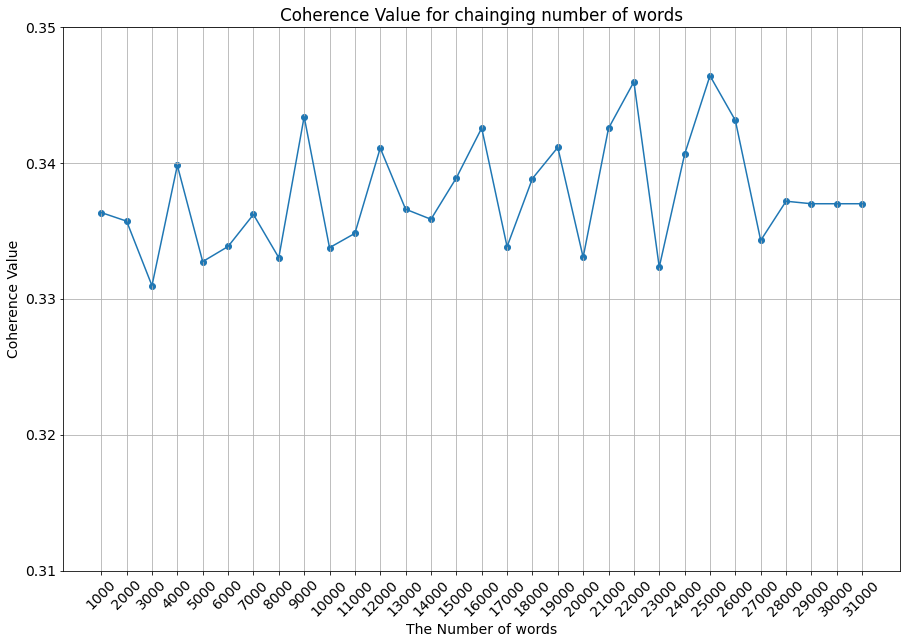

In [243]:


plt.figure(figsize=(15, 10))
plt.xlabel('The Number of words')
plt.ylabel('Coherence Value')
plt.xticks(np.arange(1000, 32000, 1000), rotation=45)
plt.yticks(np.arange(0.31, 0.36, 0.01))
plt.ylim(0.31, 0.35)
plt.grid(True)
plt.title("Coherence Value for chainging number of words")
plt.plot(compete_num_words['Num of Words'], compete_num_words['Coherence Value'])
plt.scatter(compete_num_words['Num of Words'], compete_num_words['Coherence Value'])
plt.show()


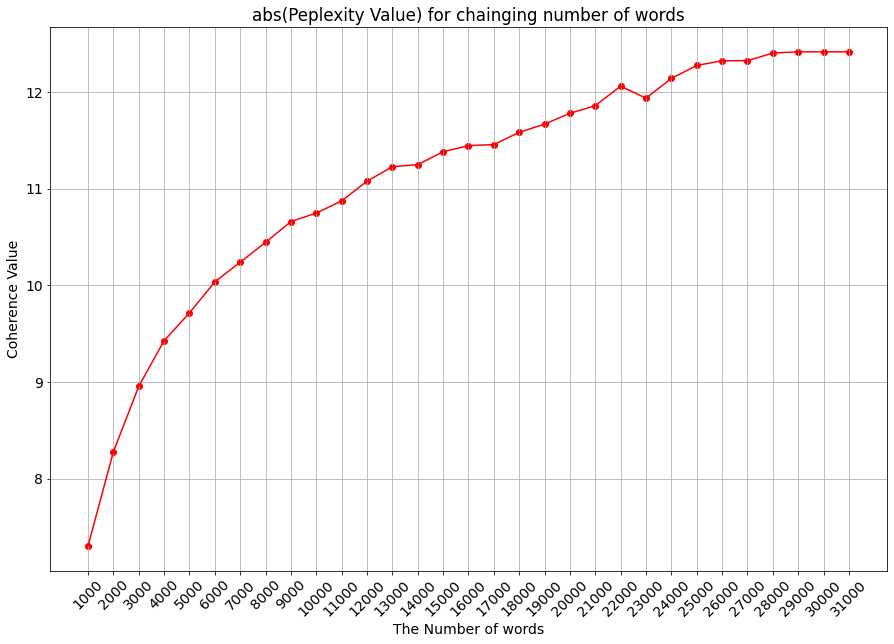

In [246]:
# Log Perplexity 값 확인

plt.figure(figsize=(15, 10))
plt.xlabel('The Number of words')
plt.ylabel('Coherence Value')
plt.xticks(np.arange(1000, 32000, 1000), rotation=45)
plt.grid(True)
plt.title("abs(Peplexity Value) for chainging number of words")
plt.plot(compete_num_words['Num of Words'], abs(compete_num_words['Perplexity Value']), 'r')
plt.scatter(compete_num_words['Num of Words'], abs(compete_num_words['Perplexity Value']), c='r')
plt.show()


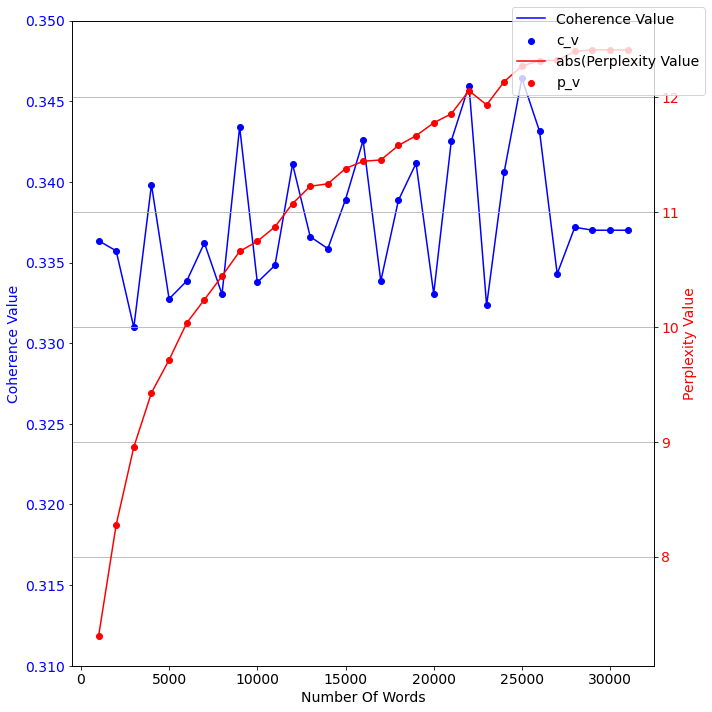

In [236]:
# 계산된 c_v와 p_v 값 같이 보여주기

fig, ax1 = plt.subplots(figsize=(10, 10))

x = np.arange(1000, 32000, 1000)
y1 = compete_num_words['Coherence Value']
y2 = abs(compete_num_words['Perplexity Value'])

ax1.set_xlabel('Number Of Words')
ax1.set_ylabel('Coherence Value', color='blue')
ax1.set_ylim(0.31, 0.35)
ax1.plot(x, y1, c='b')
ax1.scatter(x, y1, c='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()  
ax2.set_ylabel('Perplexity Value', color='red')  
ax2.plot(x, y2, c='r')
ax2.scatter(x, y2, c='r')
ax2.tick_params(axis='y', labelcolor='r')
fig.legend(['Coherence Value','c_v', 'abs(Perplexity Value', 'p_v'])
fig.tight_layout()

plt.grid()
plt.show()

# 최적의 LDA Model Parameter 찾기
찾을 하이퍼 파라미터 : n_topics, alpha, beta
지표 : Coherence Value



In [262]:
# 이전의 결과로 나타난 max_featues : 25000을 사용

best_count = CountVectorizer(max_features=25000)

count_vec =  best_count.fit_transform(detoken_xr)

corpus = Sparse2Corpus(count_vec.T)

dic = corpora.Dictionary([best_count.get_feature_names()])


In [271]:
def compute_coherence_values(corpus, id2word, k, a, b):

  lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                         id2word=id2word,
                                         num_topics=k,
                                         random_state=42, 
                                         chunksize=256, 
                                         passes=10,
                                         alpha=a,
                                         eta=b,
                                         per_word_topics=True,
                                         iterations=500)
  
  coherence_model = CoherenceModel(model=lda_model, texts=khaii_xr, dictionary=id2word, coherence='c_v')

  return coherence_model.get_coherence()


In [ ]:

# Topic Range
min_topics = 5
max_topics = 505
step_size = 5
topic_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')


model_result = pd.DataFrame(columns=['n_topic', 'alpha', 'beta', 'coherence'])
i = 0
for n_topic in topic_range:
  for a in alpha:
    for b in beta:
      print("i: {}, n_topic : {}, a : {}, b : {}".format(i+1, n_topic, a, b))
      print("=====================================================================")

      cv = compute_coherence_values(corpus=corpus, id2word=dic, k=n_topic, a=a, b=b)

      model_result.loc[i] = [n_topic, a, b, cv]
      i += 1


i: 1, n_topic : 5, a : 0.01, b : 0.01
i: 2, n_topic : 5, a : 0.01, b : 0.31
i: 3, n_topic : 5, a : 0.01, b : 0.61
i: 4, n_topic : 5, a : 0.01, b : 0.9099999999999999
i: 5, n_topic : 5, a : 0.01, b : symmetric
i: 6, n_topic : 5, a : 0.31, b : 0.01
i: 7, n_topic : 5, a : 0.31, b : 0.31
i: 8, n_topic : 5, a : 0.31, b : 0.61
i: 9, n_topic : 5, a : 0.31, b : 0.9099999999999999
i: 10, n_topic : 5, a : 0.31, b : symmetric
i: 11, n_topic : 5, a : 0.61, b : 0.01
i: 12, n_topic : 5, a : 0.61, b : 0.31
i: 13, n_topic : 5, a : 0.61, b : 0.61
i: 14, n_topic : 5, a : 0.61, b : 0.9099999999999999
i: 15, n_topic : 5, a : 0.61, b : symmetric
i: 16, n_topic : 5, a : 0.9099999999999999, b : 0.01
i: 17, n_topic : 5, a : 0.9099999999999999, b : 0.31
i: 18, n_topic : 5, a : 0.9099999999999999, b : 0.61
i: 19, n_topic : 5, a : 0.9099999999999999, b : 0.9099999999999999
i: 20, n_topic : 5, a : 0.9099999999999999, b : symmetric
i: 21, n_topic : 5, a : symmetric, b : 0.01
i: 22, n_topic : 5, a : symmetric, b : 

In [ ]:
# 최적의 coherence value 찾기

n_topic = np.arange(5, 505, 5)

co_value = pd.DataFrame(columns=['Num Topic', 'c_v'])
i = 0
for topic in n_topic:
  print("{}번째, {} 개의 topic".format(i, topic))
  LDA = LdaModel(corpus=corpus, id2word=id2word, num_topics=topic)

  c_v_LDA = CoherenceModel(model=LDA, texts=khaiii_xr, dictionary=dictionary, coherence='c_v')
  co_value.loc[i] = [topic, c_v_LDA.get_coherence()]
  i+=1

0번째, 5 개의 topic


1번째, 10 개의 topic


2번째, 15 개의 topic


3번째, 20 개의 topic


4번째, 25 개의 topic


5번째, 30 개의 topic


6번째, 35 개의 topic


7번째, 40 개의 topic


8번째, 45 개의 topic


9번째, 50 개의 topic
10번째, 55 개의 topic


11번째, 60 개의 topic


12번째, 65 개의 topic


13번째, 70 개의 topic


14번째, 75 개의 topic


15번째, 80 개의 topic


16번째, 85 개의 topic


17번째, 90 개의 topic


18번째, 95 개의 topic


19번째, 100 개의 topic


20번째, 105 개의 topic


21번째, 110 개의 topic


22번째, 115 개의 topic


23번째, 120 개의 topic


24번째, 125 개의 topic


25번째, 130 개의 topic


26번째, 135 개의 topic


27번째, 140 개의 topic


28번째, 145 개의 topic


29번째, 150 개의 topic


30번째, 155 개의 topic


31번째, 160 개의 topic


32번째, 165 개의 topic


33번째, 170 개의 topic


34번째, 175 개의 topic


35번째, 180 개의 topic


36번째, 185 개의 topic


37번째, 190 개의 topic


38번째, 195 개의 topic


39번째, 200 개의 topic


40번째, 205 개의 topic


41번째, 210 개의 topic


42번째, 215 개의 topic


43번째, 220 개의 topic


44번째, 225 개의 topic


45번째, 230 개의 topic


46번째, 235 개의 topic


47번째, 240 개의 topic


48번째, 245 개의 topic


49번째, 250 개의 topic


50번째, 255 개의 topic


51번째, 260 개의 topic


52번째, 265 개의 topic


53번째, 270 개의 topic


54번째, 275 개의 topic


55번째, 280 개의 topic


56번째, 285 개의 topic


57번째, 290 개의 topic


58번째, 295 개의 topic


59번째, 300 개의 topic


60번째, 305 개의 topic


61번째, 310 개의 topic


62번째, 315 개의 topic


63번째, 320 개의 topic


64번째, 325 개의 topic


65번째, 330 개의 topic


66번째, 335 개의 topic


67번째, 340 개의 topic


68번째, 345 개의 topic


69번째, 350 개의 topic


70번째, 355 개의 topic


71번째, 360 개의 topic


72번째, 365 개의 topic


73번째, 370 개의 topic


74번째, 375 개의 topic


75번째, 380 개의 topic


76번째, 385 개의 topic


77번째, 390 개의 topic


78번째, 395 개의 topic


79번째, 400 개의 topic


80번째, 405 개의 topic


81번째, 410 개의 topic


82번째, 415 개의 topic


83번째, 420 개의 topic


84번째, 425 개의 topic


85번째, 430 개의 topic


86번째, 435 개의 topic


87번째, 440 개의 topic


88번째, 445 개의 topic


89번째, 450 개의 topic


90번째, 455 개의 topic


91번째, 460 개의 topic


92번째, 465 개의 topic


93번째, 470 개의 topic


94번째, 475 개의 topic


95번째, 480 개의 topic


96번째, 485 개의 topic


97번째, 490 개의 topic


98번째, 495 개의 topic


99번째, 500 개의 topic


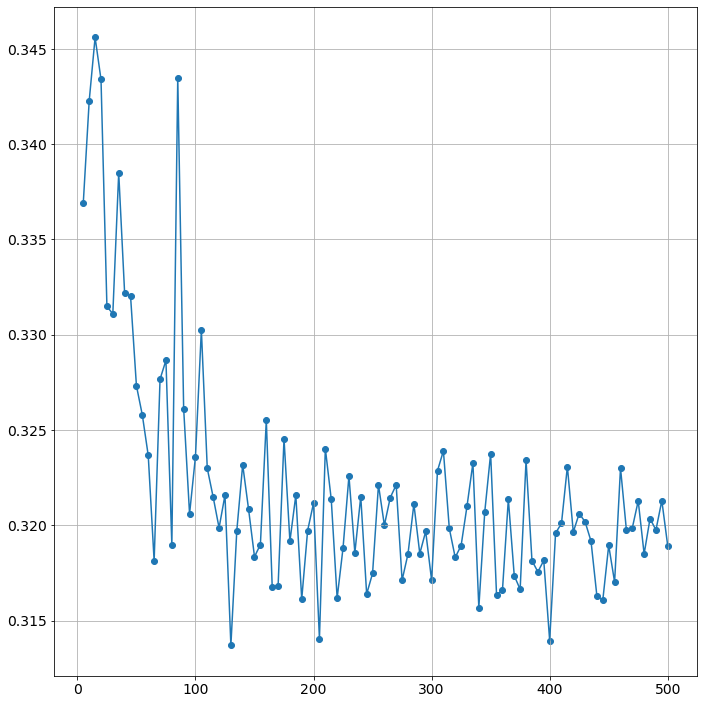

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(co_value['Num Topic'], co_value['c_v'])
plt.scatter(co_value['Num Topic'], co_value['c_v'])
plt.ylim(0.30, 0.35)
#plt.xticks(np.arange(5, 505, 5), rotation=90)
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
n_min_df = [0.0001, 0.001, 0.01, 0.1, 1, 2, 3]


result = pd.DataFrame()

for min_df in n_min_df:
  temp_topic = {}
  vectorizer = CountVectorizer(min_df=min_df)
  vect = vectorizer.fit_transform(detokenized_doc)
  terms = vectorizer.get_feature_names()

  for topics in n_topic:
    lda = LatentDirichletAllocation(n_components=topics)
    lda.fit_transform(vect.toarray())
    temp_topic = get_topics(lda.components_, terms)
    temp_topic['n_df'] = min_df
    temp_topic['n_topic'] = topics


    temp = pd.DataFrame.from_dict(temp_topic)
    result = pd.concat([result, temp], axis=0)
    


KeyboardInterrupt: ignored

In [ ]:
result = result[['n_df', 'n_topic', 'Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5', 'Topic 6','Topic 7', 'Topic 8', 'Topic 9', 'Topic 10','Topic 11', 'Topic 12']]

In [ ]:
result.to_csv('Topic 결과_final.csv', encoding='utf-8')